## Libs

In [1]:
import pandas as pd
import numpy as np
import warnings
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import STL


warnings.filterwarnings('ignore')
sns.set_style('darkgrid') # darkgrid, darkgrid

## Funcs

In [3]:
def make_df(file_path):
    df = pd.read_csv(file_path, index_col='date', sep=';')
    df['date'] = pd.to_datetime(df.index)
    df.set_index('date', inplace=True)
    df.head()
    return df


def replace_spaces_in_strings(df):
    for col in df.columns:
        if df[col].dtype == 'O':
            df[col] = df[col].str.replace(' ', '').astype('float64')
        if df[col].dtype == 'int64':
            df[col] = df[col].astype('float64')


def scale_series(series, scale=1):
    scaled = series * (1 / scale)
    return scaled


def scale_df(df, thsnds_col=None, mlns_col=None):
    if thsnds_col is not None:
        for col in df[thsnds_col]:
            df[col] = df[col].apply(scale_series, scale=1_000)
    if mlns_col is not None:
        for col in df[mlns_col]:
            df[col] = df[col].apply(scale_series, scale=1_000_000)

def print_data_info(df):
    # Data Summary
    print('Data Shape:', df.shape)
    print('\nData Types:')
    print(df.dtypes)

    # Missing Values Check
    print('\nMissing Values:')
    print(df.isnull().sum())

    # info about dataframe 
    print(df.info())

    # Statistical Summary
    print('\nStatistical Summary:')
    print(df.describe())

    # Adjusting the layout to accommodate all numerical columns
    num_columns = df.select_dtypes(include=['number']).shape[1]

    # Print correlations
    print(df.corr())
    print(sns.heatmap(df.corr()))


    rows = num_columns // 3 + (num_columns % 3 > 0)

    # Histograms for each numerical variable
    df.hist(bins=15, figsize=(15, rows * 5), layout=(rows, 3))
    plt.tight_layout()
    plt.show()


    # Box plots for each numerical variable
    df.plot(kind='box', subplots=True, layout=(rows, 3), figsize=(15, rows * 5), sharex=False, sharey=False)
    plt.tight_layout()
    plt.show()



## Import data

In [6]:
file_path = '../data/data_demo.csv'

df = make_df(file_path)

df.head(3)

,old_sales,sales,price,queries,visits_cost,visits_count,banner_quant,banner_cost,banner_cost_new,context_quant,...,tvr_creative_1,tvr_creative_2,tvr_creative_3,tv_cost,tvr_competitor_1,tvr_competitor_2,tvr_competitor_3,tvr_competitor_4,tvr_competitor_5,tvr_competitor_6
date,,,,,,,,,,,,,,,,,,,,,
2018-12-31,102530,95353,143,645354,1508543,2193,0,0,0,9221,...,0,0,0,0,205,397,253,121,249,331
2019-01-07,133632,124278,143,615454,1508543,2193,0,0,0,9221,...,281,0,0,12490514,270,433,202,204,248,319
2019-01-14,135094,125637,143,573170,2724790,3960,0,0,0,9221,...,222,0,0,9835858,228,235,136,206,270,284


## Preprocessing

In [7]:
replace_spaces_in_strings(df)


df['tvr'] = df[[
    'tvr_creative_1', 
    'tvr_creative_2', 
    'tvr_creative_3'
]].sum(axis=1)


scale_df(df,
         thsnds_col=[
            'old_sales',
            'sales',
            'queries',
            'visits_cost',
            'banner_cost',
            'banner_cost_new',
            'olv_cost',
            'olv_cost_new',
            'social_cost',
            'social_cost_new',
            'tv_cost',
         ]
)
# df.describe()[thsnds_col].loc['mean', :]




Data Shape: (170, 29)

Data Types:
old_sales           float64
sales               float64
price               float64
queries             float64
visits_cost         float64
visits_count        float64
banner_quant        float64
banner_cost         float64
banner_cost_new     float64
context_quant       float64
context_cost        float64
context_cost_new    float64
olv_quant           float64
olv_cost            float64
olv_cost_new        float64
social_quant        float64
social_cost         float64
social_cost_new     float64
tvr_creative_1      float64
tvr_creative_2      float64
tvr_creative_3      float64
tv_cost             float64
tvr_competitor_1    float64
tvr_competitor_2    float64
tvr_competitor_3    float64
tvr_competitor_4    float64
tvr_competitor_5    float64
tvr_competitor_6    float64
tvr                 float64
dtype: object

Missing Values:
old_sales           0
sales               0
price               0
queries             0
visits_cost         0
visits_count

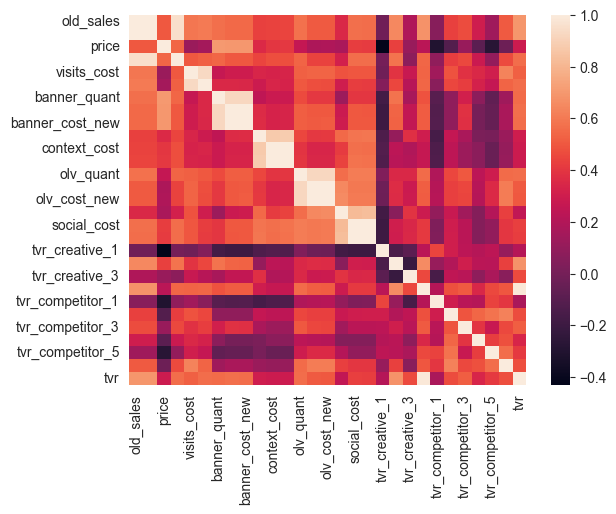

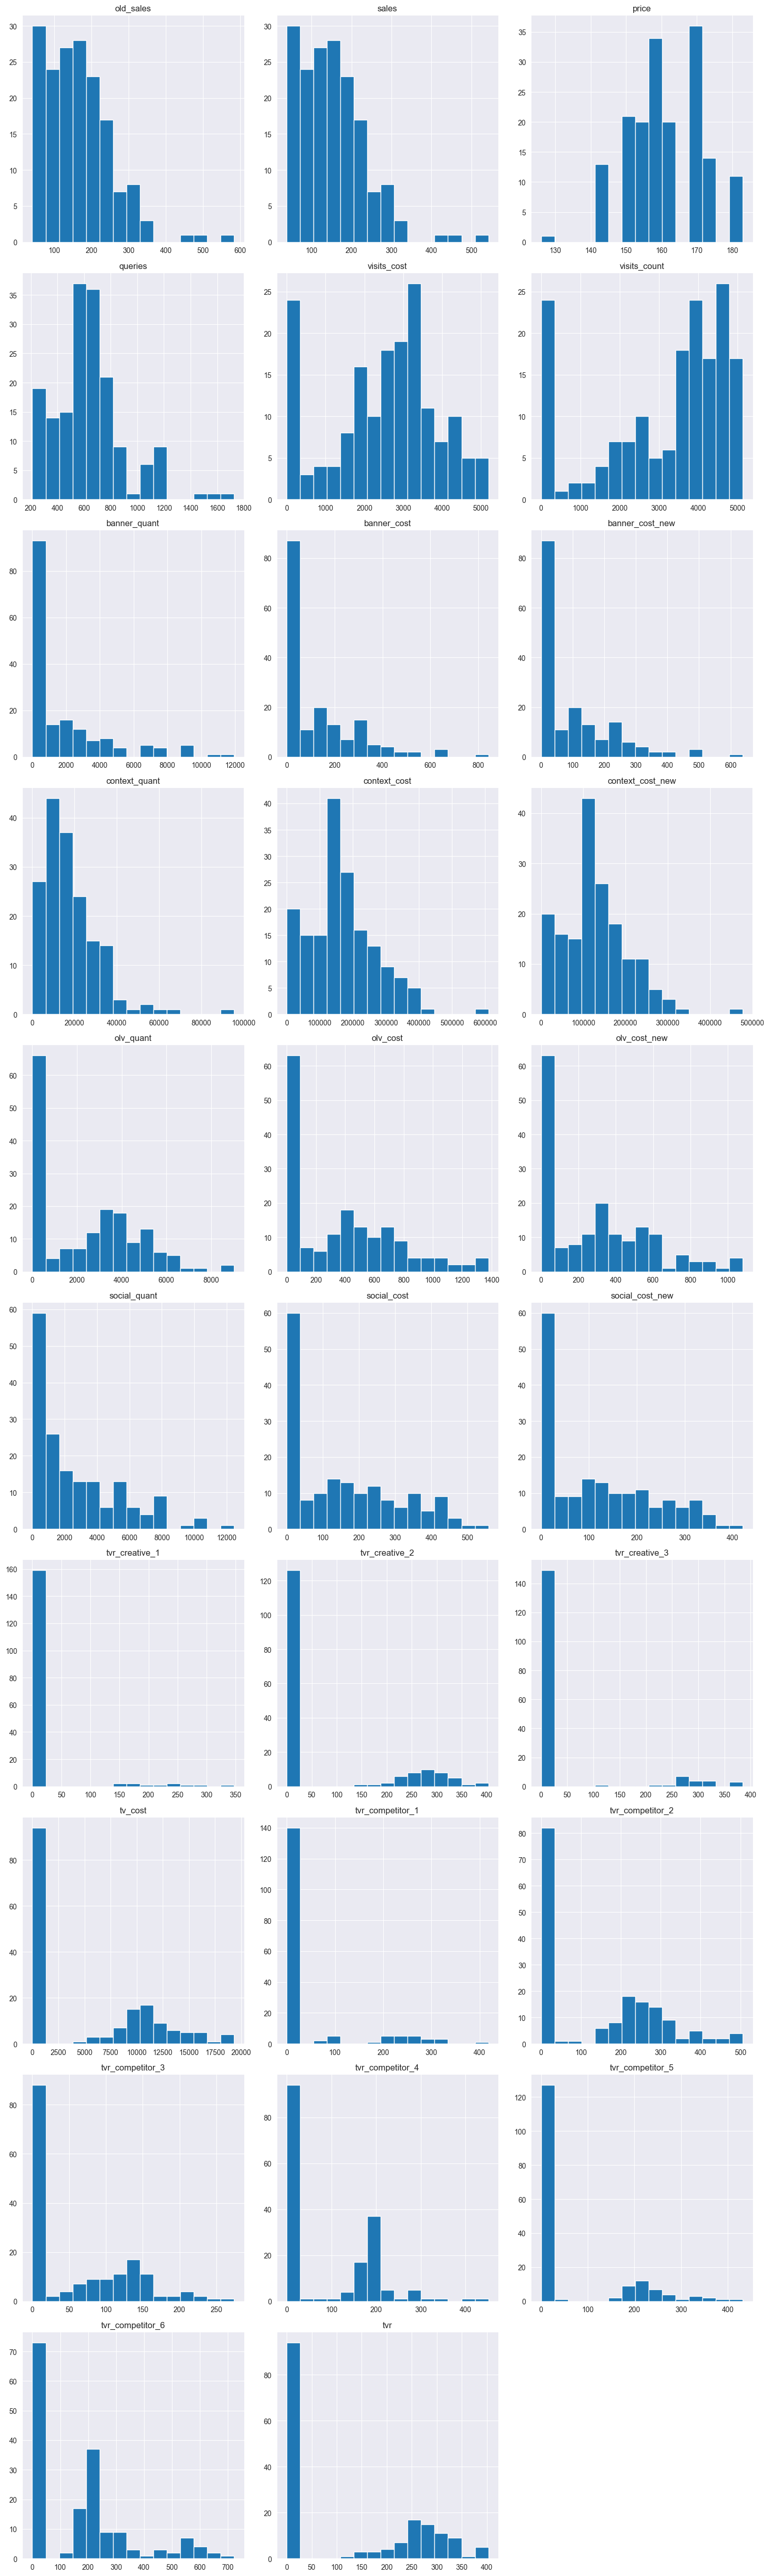

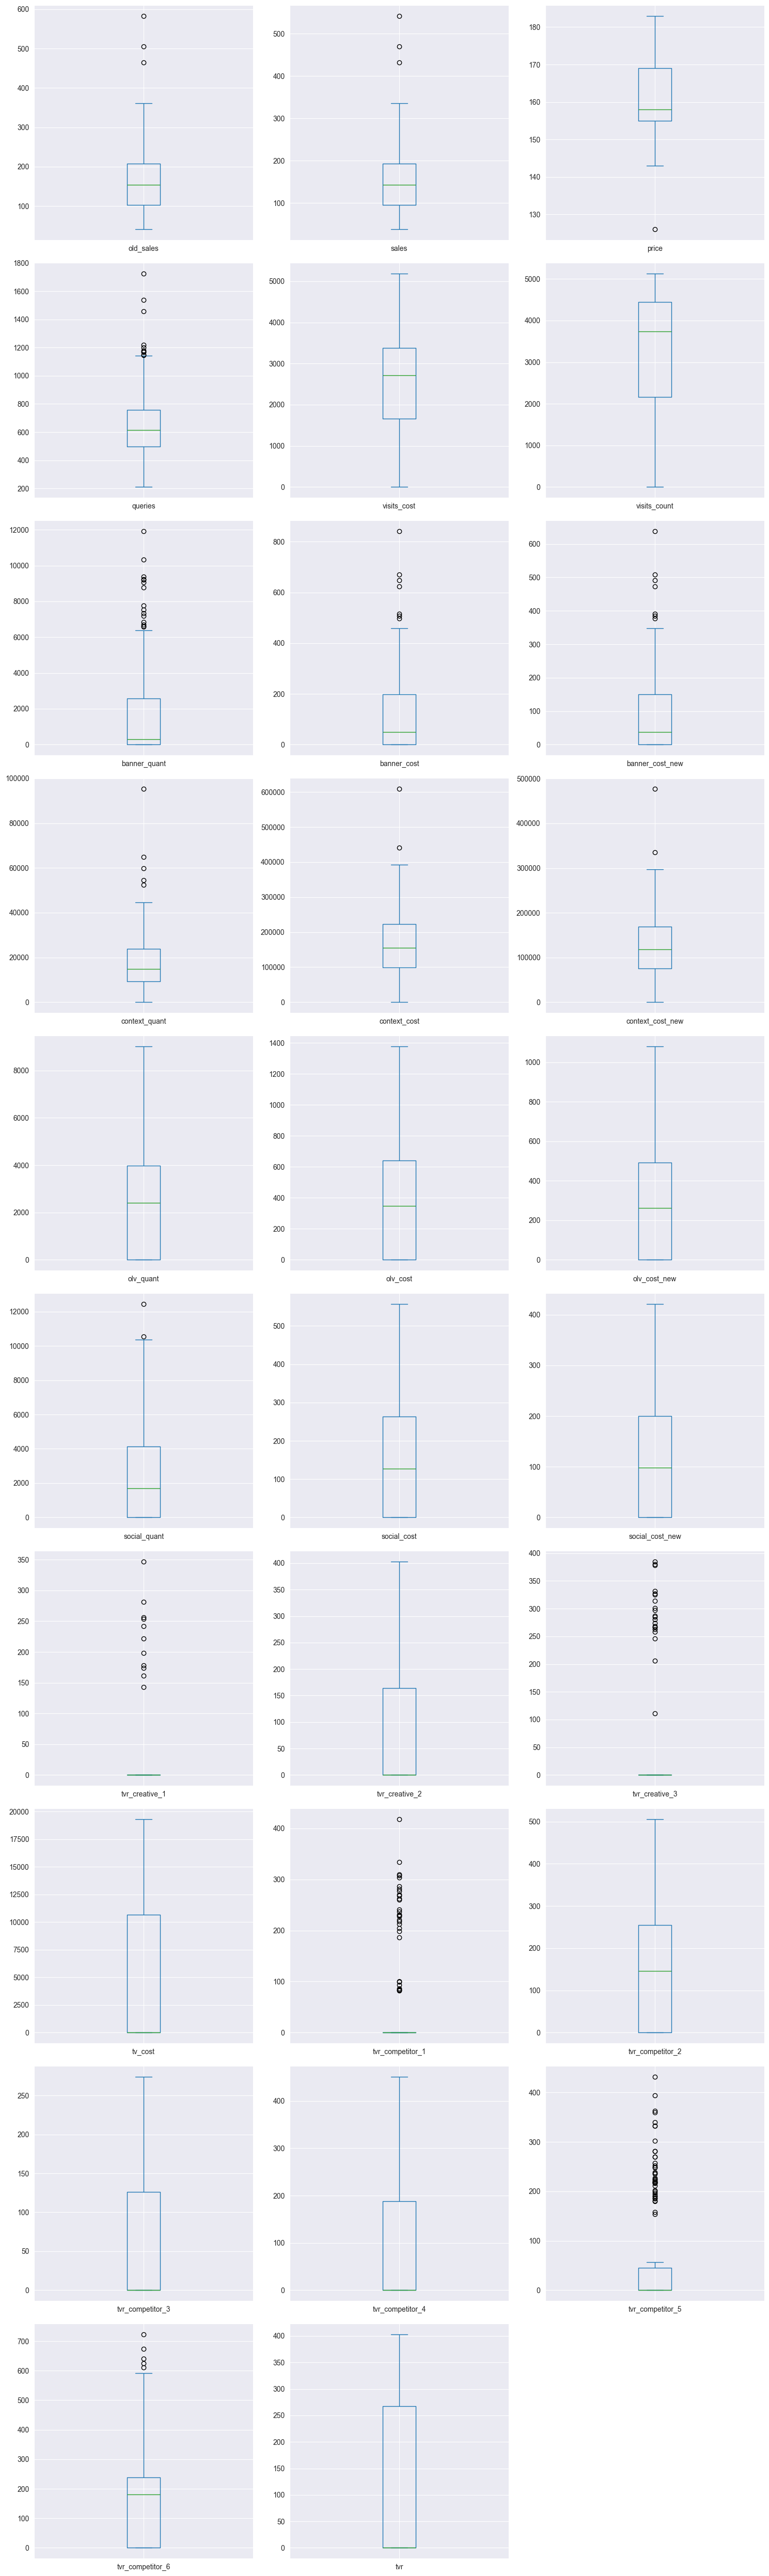

In [8]:
print_data_info(df)

## Compare two models

In [9]:
y = df['sales']

X1 = df[['tv_cost', 'olv_cost']]
X1 = sm.add_constant(X1)

X2 = df[['tvr', 'olv_cost']]
X2 = sm.add_constant(X2)

X3 = df[['tv_cost', 'olv_cost', 'visits_cost']]
X3 = sm.add_constant(X3)


models = [
    sm.OLS(y, X1).fit(),
    sm.OLS(y, X2).fit(),
    sm.OLS(y, X3).fit()
]

# Combine summaries into a single dataframe
summary_table = summary_col(models, float_format='%0.4f', stars=True)

# Convert the summary table to a pandas dataframe
summary_df = pd.DataFrame(summary_table.tables[0])

# Print or display the consolidated summary dataframe
summary_df

,sales I,sales II,sales III
R-squared,0.4957,0.5090,0.5430
R-squared Adj.,0.4897,0.5031,0.5348
const,95.8094***,93.9482***,70.0301***
,(6.6499),(6.6032),(8.8883)
olv_cost,0.0457***,0.0458***,0.0245*
,(0.0142),(0.0139),(0.0145)
tv_cost,0.0078***,,0.0064***
,(0.0009),,(0.0009)
tvr,,0.3415***,
,,(0.0367),


## Seasonality Extraction

### STL extraction trend, seasonality

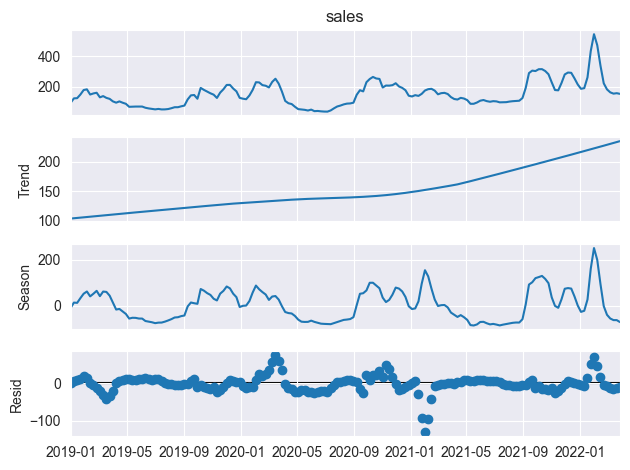

In [44]:
# from statsmodels.tsa.seasonal import STL
model_stl = STL(y).fit()
model_stl.plot()
plt.show()

### Create new dates for continuining trend and seasonality pattern (very basic scenario)

In [53]:
future_dates = pd.date_range(start='2022-04-04', periods=12, freq='W')

future_X = pd.DataFrame(index=future_dates, columns=df_timeseries.columns)

future_X['res_stl_trend'] = model_stl.trend[-1]  # Assuming trend continues
future_X['res_stl_seasonal'] = np.tile(model_stl.seasonal.tail(7).values, 2)[:12]  # Use the last observed seasonal pattern
future_X['res_stl_resid'] = 0  # Assuming no residual for simplicity

future_X

,res_stl_resid,res_stl_trend,res_stl_seasonal
2022-04-10,0,234.689269,93.824363
2022-04-17,0,234.689269,-1.018038
2022-04-24,0,234.689269,-38.598230
2022-05-01,0,234.689269,-54.610749
2022-05-08,0,234.689269,-61.518036
2022-05-15,0,234.689269,-61.615357
2022-05-22,0,234.689269,-70.158990
2022-05-29,0,234.689269,93.824363
2022-06-05,0,234.689269,-1.018038
2022-06-12,0,234.689269,-38.598230


In [58]:
# Extrapolate the trend into the future using the last observed slope

last_observed_slope = model_stl.trend.diff().iloc[-1]
future_X['trend_2'] = model_stl.trend[-1] + np.arange(1, 13) * last_observed_slope


In [61]:
last_observed_slope

1.5501334009899495

In [63]:
np.arange(1, 13) * last_observed_slope

array([ 1.5501334 ,  3.1002668 ,  4.6504002 ,  6.2005336 ,  7.750667  ,
        9.30080041, 10.85093381, 12.40106721, 13.95120061, 15.50133401,
       17.05146741, 18.60160081])

In [65]:
future_X['trend_3'] = model_stl.trend[-1] + 1 * last_observed_slope

In [68]:
future_X

,res_stl_resid,res_stl_trend,res_stl_seasonal,trend_2,trend_3
2022-04-10,0,234.689269,93.824363,236.239402,236.239402
2022-04-17,0,234.689269,-1.018038,237.789536,236.239402
2022-04-24,0,234.689269,-38.598230,239.339669,236.239402
2022-05-01,0,234.689269,-54.610749,240.889803,236.239402
2022-05-08,0,234.689269,-61.518036,242.439936,236.239402
2022-05-15,0,234.689269,-61.615357,243.990069,236.239402
2022-05-22,0,234.689269,-70.158990,245.540203,236.239402
2022-05-29,0,234.689269,93.824363,247.090336,236.239402
2022-06-05,0,234.689269,-1.018038,248.640470,236.239402
2022-06-12,0,234.689269,-38.598230,250.190603,236.239402


## To Do

### Forecasting trend and seasonality with ARIMA

### Extract and forecast trend, seasonality with Prophet

### Extract and forecast trend, seasonality with oter tool